<a href="https://colab.research.google.com/github/icsd13152/Sentiment_Analysis_Covid19/blob/main/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn import feature_extraction, model_selection
!pip install transformers
from transformers import BertTokenizer,BertModel, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import tensorflow as tf
import tensorflow_datasets as tfds
# !pip install --upgrade tensorflow_hub
import tensorflow_hub as hub
# !pip install tensorflow-text
import nltk
#import tensorflow_text as text
from nltk.corpus import  wordnet
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 62.4 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
     |████████████████████████████████| 6.6 MB 44.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
import shutil
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Pre-processing of Tweets

Η προεπεξεργασία των κειμένων είναι ίδια με αυτή της απλής προσέγγισης ML.

In [3]:
data = pd.read_csv(r"/content/drive/My Drive/NLP/Project/Corona_NLP_train.csv",encoding='latin-1')



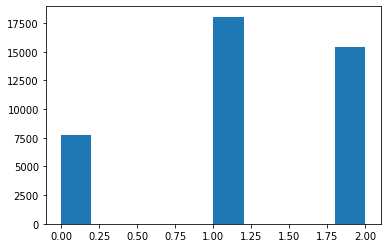

In [4]:
data["Sentiment"] = data["Sentiment"].replace('Extremely Negative', 'Negative', regex=True)

data["Sentiment"] = data["Sentiment"].replace('Extremely Positive', 'Positive', regex=True)

#transform Sentiment to number
#negative=0
#postive=1
#neutral=2
data["Sentiment"]=data["Sentiment"].replace('Negative', 2, regex=True)
data["Sentiment"]=data["Sentiment"].replace('Positive', 1, regex=True)
data["Sentiment"]=data["Sentiment"].replace('Neutral', 0, regex=True)


plt.hist(data["Sentiment"])
plt.show()

In [5]:
#short words/apostrophe lookup
contraction_dict1 = {"Â":"","’":"'","Ã":""}
contraction_dict2 = {"Â":"","’":"'","ain't": "are not","'s":" is","aren't": "are not","don't": "do not","Don't":"Do not",
                     "I'll":"I will","Didn't":"Did not","hasn't":"has not","NYC":"New York City","16MAR20":"",
                     "I'd":"I would","I've":"I have","you're":"you are","I'm":"I am","it's":"it is",
                     "#NZ":"","they'll":"they will","they're":"they are","can't":"can not","Y'all":"You All",
                     "I m":"I am","can't":"can not","don t":"do not","I ve":"I have","we're":"we are",
                     "LOL":"lough out loud","lol":"lough out loud","FYI":"For your information","OFC":"Of Course","ofc":"Of Course",
                     "#coronavirÃ¼s":"coronavirus","pls":"please","#stayhomesavelives":"stay home save lives",
                     "hasn't": 'has not',"haven't": 'have not',"he'd": 'he had / he would',"he'd've": 'he would have',
                     "he'll": 'he shall / he will',"he'll've": 'he shall have / he will have',
                     "he's": 'he has / he is',"how'd": 'how did', "how'd'y": 'how do you', "how'll": 'how will',
                     "how's": 'how has / how is', "i'd": 'I had / I would',"i'd've": 'I would have',  "i'll": 'I shall / I will',
                     "i'll've": 'I shall have / I will have',"i'm": 'I am', "i've": 'I have', "isn't": 'is not', "it'd": 'it had / it would',
                     "it'd've": 'it would have', "it'll": 'it shall / it will',
                     "it'll've": 'it shall have / it will have',"it's": 'it has / it is', "let's": 'let us',
                     "ma'am": 'madam', "mayn't": 'may not',
                     "might've": 'might have', "mightn't": 'might not',
                     "mightn't've": 'might not have', "must've": 'must have',"mustn't": 'must not',
                     "mustn't've": 'must not have', "needn't": 'need not',
                     "needn't've": 'need not have', "o'clock": 'of the clock',
                     "oughtn't": 'ought not', "oughtn't've": 'ought not have',
                     "shan't": 'shall not', "sha'n't": 'shall not',
                     "shan't've": 'shall not have', "she'd": 'she had / she would',
                     "she'd've": 'she would have', "she'll": 'she shall / she will',
                     "she'll've": 'she shall have / she will have',
                     "she's": 'she has / she is', "should've": 'should have',
                     "shouldn't": 'should not',"shouldn't've": 'should not have',
                     "so've": 'so have', "so's": 'so as / so is',
                     "that'd": 'that would / that had',"that'd've": 'that would have',
                     "that's": 'that has / that is', "there'd": 'there had / there would',
                     "there'd've": 'there would have', "there's": 'there has / there is',
                     "they'd": 'they had / they would',  "they'd've": 'they would have',
                     "they'll": 'they shall / they will', "they'll've": 'they shall have / they will have',
                     "they're": 'they are',  "they've": 'they have',
                     "to've": 'to have', "wasn't": 'was not',
                     "we'd": 'we had / we would',  "we'd've": 'we would have',
                     "we'll": 'we will', "we'll've": 'we will have',
                     "we're": 'we are', "we've": 'we have',
                     "weren't": 'were not', "what'll": 'what shall / what will',
                     "what'll've": 'what shall have / what will have',
                     "what're": 'what are', "what's": 'what has / what is',
                     "what've": 'what have',"when's": 'when has / when is',
                     "when've": 'when have', "where'd": 'where did',
                     "where's": 'where has / where is',
                     "where've": 'where have', "who'll": 'who shall / who will',
                     "who'll've": 'who shall have / who will have',
                     "who's": 'who has / who is', "who've": 'who have',
                     "why's": 'why has / why is', "why've": 'why have',
                     "will've": 'will have', "won't": 'will not',"won't've": 'will not have',
                     "would've": 'would have',"wouldn't": 'would not',"wouldn't've": 'would not have',
                     "y'all": 'you all', "y'all'd": 'you all would',
                     "y'all'd've": 'you all would have', "y'all're": 'you all are',
                     "y'all've": 'you all have', "you'd": 'you had / you would',
                     "you'd've": 'you would have',"&amp":"and","btc":"bitcoin","irs":"","spx":"","📍":"","✅":"","ive":"i have",
                     "coo":"","lka":"", "nyc":"","ktla":"","ppc":"pay per click","wjhl":"","plzzz":"please","orlf":"","etc":"",
                     "ktvu":"","amidst":"","biz":"business","djt":"","ict":"information communications technology","yep":"yes",
                     "yeap":"yes","letâs":"let","didn't":"did not","regionâs":"regions","covid-19":"covid","iâm":"I am","coronavir¼":"coronavirus",
                     "weÃ¢ve":"we have","Ã¢today":"today","deliveriesÃ¢as":"deliveries","canÃ¢t":"can not","itÃ¢s":"it is","thereÃ¢s":"thereÃ¢s",
                     "donÃ¢t":"do not","iÃ¢ve":"i have","consumerÃ¢s":"consumer","didnÃ¢t":"did not","billÃ¢":"bill","thatÃ¢s":"that is"
                     }

emoticons={':)': 'happy', ':‑)': 'happy',
 ':-]': 'happy', ':-3': 'happy',
 ':->': 'happy', '8-)': 'happy',
 ':-}': 'happy', ':o)': 'happy',
 ':c)': 'happy', ':^)': 'happy',
 '=]': 'happy', '=)': 'happy',
 '<3': 'happy', ':-(': 'sad',
 ':(': 'sad', ':c': 'sad',
 ':<': 'sad', ':[': 'sad',
 '>:[': 'sad', ':{': 'sad',
 '>:(': 'sad', ':-c': 'sad',
 ':-< ': 'sad', ':-[': 'sad',
 ':-||': 'sad',
  '😢':'sad'         }

myOwnStopWords={'price':"",
               'store':"",
               'supermarket':"",
               'food':"",
               'grocery':"",
               'people':"",
               'go':"",
               'consumer':"",
                'usdjpy':"", 'gbpusd':"", 'usdcnh':"", 'xauusd':"", 'wti':"", 'spx':"",'iave':"","aiave":"","itâs":"it is"}

In [6]:
def lookup_dict(text, dictionary):
    if isinstance(text, float) == False and text is not None:
        for word in text.split():
            if word.lower() in dictionary:
                if word.lower() in text.split():
                    text = text.replace(word, dictionary[word.lower()])
        return text

In [7]:
from sklearn.model_selection import train_test_split
data["OriginalTweet"] = data["OriginalTweet"].apply(lambda x: lookup_dict(x,emoticons))

data['OriginalTweet']=data['OriginalTweet'].apply(lambda x:lookup_dict(x,contraction_dict1))
data['OriginalTweet']=data['OriginalTweet'].apply(lambda x:lookup_dict(x,contraction_dict2))
data['OriginalTweet']  = data['OriginalTweet'].str.lower()
data['OriginalTweet']=data['OriginalTweet'].apply(lambda x:lookup_dict(x,contraction_dict2))
data['OriginalTweet'] = data['OriginalTweet'].apply(lambda x: ''.join(''.join(s)[:2] for _, s in itertools.groupby(x)))


#to lower case
data['OriginalTweet']  = data['OriginalTweet'].str.lower()
#remove numbers
data["OriginalTweet"] = data["OriginalTweet"].replace('[0-9]', '', regex=True)

#remove mentions
data["OriginalTweet"] = data["OriginalTweet"].replace('@([a-zA-Z0-9_]{1,50})', '', regex=True)

#remove hashtags
data["OriginalTweet"] = data["OriginalTweet"].replace('#', '', regex=True)
data["OriginalTweet"] = data["OriginalTweet"].replace('â', '', regex=True)
#remove urls
data["OriginalTweet"] = data["OriginalTweet"].replace('http\S+', '', regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("_", "", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace(",", " ", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("   ", " ", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("  ", " ", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("\?", " ", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("pmmodi", "", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("amp", "and", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("btc", "bitcoin", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("hand", "", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].fillna(0)
data['OriginalTweet']=data['OriginalTweet'].apply(lambda x:lookup_dict(x,contraction_dict2))
data["OriginalTweet"]=data["OriginalTweet"].replace("\r\r\n", "", regex=True)
# # #remove all remaining bad chars
data["OriginalTweet"]=data["OriginalTweet"].replace('[^\\w\\s]', '', regex=True)
data['OriginalTweet']  = data['OriginalTweet'].str.strip()
data['OriginalTweet'].fillna(value='', inplace=True)
#Tokenize the tweets
tokenized_tweets = data["OriginalTweet"].apply(lambda x: x.split())

#remove stopword(for example and,to at etc)
stop_words = set(stopwords.words('english'))
tokenized_tweets = tokenized_tweets.apply(lambda x: [word for word in x if not word in stop_words])

#Stemming the words
# stemmer = PorterStemmer()#language='english'
# tokenized_tweets= tokenized_tweets.apply(lambda x: [stemmer.stem(i) for i in x])

def get_pos( word ):
    w_synsets = wordnet.synsets(word)

    pos_counts = nltk.Counter()
    pos_counts["n"] = len(  [ item for item in w_synsets if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in w_synsets if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in w_synsets if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in w_synsets if item.pos()=="r"]  )

    most_common_pos_list = pos_counts.most_common(3)
    return most_common_pos_list[0][0]
#get the lemma
lemmatizer = WordNetLemmatizer()

tokenized_tweets = tokenized_tweets.apply(lambda x: [lemmatizer.lemmatize(i,get_pos( i )) for i in x])

# tokenized_tweets = tokenized_tweets.apply(lambda x: [word for word in x if len(word)>2 or word=='go'])


#Joining the tokenized tweets
for i in range(len(tokenized_tweets)):
    tokenized_tweets[i] = ' '.join(tokenized_tweets[i])
data["OriginalTweet"] = tokenized_tweets


data['OriginalTweet']=data['OriginalTweet'].apply(lambda x:lookup_dict(x,myOwnStopWords))
all_words = []
for line in list(data['OriginalTweet']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())



data["OriginalTweet"]=data["OriginalTweet"].replace("  ", " ", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace(" +", " ", regex=True)
data['OriginalTweet']  = data['OriginalTweet'].str.strip()

data.drop_duplicates(subset ="OriginalTweet",
                         keep = 'last', inplace = True)
data.reset_index(drop=True, inplace=True)

data.to_csv('raw_data2.csv', index=False)
# X_train, X_test, y_train, y_test = train_test_split(data['OriginalTweet'],data['Sentiment'], test_size=0.25,shuffle=True, stratify=data['Sentiment'])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(data.index.values,data['Sentiment'], test_size=0.25,stratify=data['Sentiment'])

In [ ]:
data['data_type'] = ['not_set'] * data.shape[0]

In [ ]:

data.loc[X_train, 'data_type'] = 'train'
data.loc[X_val, 'data_type'] = 'val'

#groupby count
data.groupby(['Sentiment','data_type']).count()


UserName  ScreenName  Location  TweetAt  OriginalTweet
Sentiment data_type                                                        
0         train          5704        5704      4535     5704           5704
          val            1902        1902      1553     1902           1902
1         train         13456       13456     10732    13456          13456
          val            4486        4486      3574     4486           4486
2         train         11473       11473      8948    11473          11473
          val            3824        3824      2987     3824           3824

# Bert Tokenizer

Παρακάτω θα κατεβάσουμε και θα φορτώσουμε το tokenizer model του BERT, έτσι ώστε να έχουμε τα tokens που προκύπτουν απο το BERT με σκοπό να τα δώσουμε ως είσοδο στο BERT Encoder

In [ ]:
# !pip install transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased',
                                         do_lower_case = True)

Παρακάτω θα κάνουμε tokenize τα κείμενα με τον Tokenizer του BERT. Επίσης θα τα κάνουμε και encode με padding ως προς το μέγιστο μήκος ακολουθίας. Το οποίο μήκος το ορίσαμε hard-coded στα 64 για να αποφύγουμε το overload της μνήμης, καθώς το Colab θέτει περιορισμούς.

In [ ]:
#encode train set
encoded_data_train = tokenizer.batch_encode_plus(data[data.data_type == 'train'].OriginalTweet.values,
                                                # add_special_tokes = True,
                                                return_attention_mask = True,
                                                padding=True,
                                                max_length = 64,
                                                return_tensors = 'pt')
                                                
#encode validation set
encoded_data_val = tokenizer.batch_encode_plus(data[data.data_type == 'val'].OriginalTweet.values,
                                                # add_special_tokes = True,
                                                return_attention_mask = True,
                                                padding=True,
                                                max_length = 64,
                                                return_tensors = 'pt')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2302: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


Το BERT αντιστοιχεί το κάθε token με ένα index και ορίζει και το attention mask.

In [ ]:
#train set
import torch
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
print(data[data.data_type == 'train'].Sentiment.values)
labels_train = torch.tensor(data[data.data_type == 'train'].Sentiment.values.astype(int))

#validation set
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(data[data.data_type == 'val'].Sentiment.values.astype(int))
print(labels_train)

[1 1 1 ... 1 0 2]
tensor([1, 1, 1,  ..., 1, 0, 2])


# Bert Model

Παρακάτω υλοποιούμε την αρχιτεκτονική του μοντέλου μας. Στην ουσία ορίζουμε όλη την αρχιτεκτονική ενός BERT με extra Fully connected Layer δικό μας το οποίο δέχεται ως είσοδο τα 768 Features που βγάζει το BERT και κάνει το Classification. Το τελικό output είναι το probability distribution της κάθε κλάσης.

In [ ]:
from transformers import BertForSequenceClassification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased',
                                                      num_labels = 3,
                                                      output_attentions = False,
                                                      output_hidden_states = False).to(device)
for param in model.parameters():
    param.requires_grad = True

num_ftrs = model.classifier.in_features
model.classifier = torch.nn.Linear(num_ftrs, 3)
# embeddings = model.get_output_embeddings()
model = model.to(device)

Downloading:   0%|          | 0.00/641M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [ ]:
from torch.utils.data import TensorDataset

#train set
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

#validation set
dataset_val = TensorDataset(input_ids_val, 
                             attention_masks_val, 
                             labels_val)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 64

#train set
dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = batch_size)

#validation set
dataloader_val = DataLoader(dataset_val,
                              sampler = RandomSampler(dataset_val),
                              batch_size = 64)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                 lr = 1e-5,
                 eps = 1e-8) #2e-5 > 5e-5
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 10

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = len(dataloader_train)*epochs)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from tqdm import tqdm

# def avg_fscore(n_model, data, labels):
#     device = next(model.parameters()).device
#     with torch.no_grad():
#         output = n_model(data.to(device))
#     softmax = torch.exp(output)
#     #prob = list(softmax.numpy())
#     predictions = torch.argmax(softmax, -1)
#     return f1_score(labels.cpu().data.numpy(), predictions.cpu().data.numpy(), average='macro')

def evaluate(dataloader_val,ep):
    model.load_state_dict(torch.load(f'Models/BERT_ft_epoch{ep}.model'))
    #evaluation mode 
    model.eval()
    
    #tracking variables
    loss_val_total = 0
    valF1 = list()
    predictions, true_vals = [], []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    progress_bar = tqdm(dataloader_val, 
                        desc = 'Epoch {:1d}'.format(ep), 
                        leave = False, 
                        disable = False)
    for batch in tqdm(dataloader_val):
        
        #load into GPU
        batch = tuple(b.to(device) for b in batch)
        
        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():        
            outputs = model(**inputs)
        
        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        progress_bar.set_postfix({'validation_loss': '{:.3f}'.format(loss.item() / len(batch))})
        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    # valF1.append(avg_fscore(model, **inputs, true_vals))
    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
# import numpy as np
# from sklearn.metrics import f1_score
# def convert_to_array(seq):
#     return np.array(seq)

# def f1_score_func(preds, labels):
#     preds_flat = np.argmax(preds, axis = 1).flatten().numpy()
#     print(preds_flat)
#     labels_flat = labels.flatten().numpy()
#     print(labels_flat)
#     return f1_score(labels_flat, preds, average = 'weighted')
from typing import Tuple

import torch


class F1Score:
    """
    Class for f1 calculation in Pytorch.
    """

    def __init__(self, average: str = 'weighted'):
        """
        Init.

        Args:
            average: averaging method
        """
        self.average = average
        if average not in [None, 'micro', 'macro', 'weighted']:
            raise ValueError('Wrong value of average parameter')

    @staticmethod
    def calc_f1_micro(predictions: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Calculate f1 micro.

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels

        Returns:
            f1 score
        """
        true_positive = torch.eq(labels, predictions).sum().float()
        f1_score = torch.div(true_positive, len(labels))
        return f1_score

    @staticmethod
    def calc_f1_count_for_label(predictions: torch.Tensor,
                                labels: torch.Tensor, label_id: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Calculate f1 and true count for the label

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels
            label_id: id of current label

        Returns:
            f1 score and true count for label
        """
        # label count
        true_count = torch.eq(labels, label_id).sum()

        # true positives: labels equal to prediction and to label_id
        true_positive = torch.logical_and(torch.eq(labels, predictions),
                                          torch.eq(labels, label_id)).sum().float()
        # precision for label
        precision = torch.div(true_positive, torch.eq(predictions, label_id).sum().float())
        # replace nan values with 0
        precision = torch.where(torch.isnan(precision),
                                torch.zeros_like(precision).type_as(true_positive),
                                precision)

        # recall for label
        recall = torch.div(true_positive, true_count)
        # f1
        f1 = 2 * precision * recall / (precision + recall)
        # replace nan values with 0
        f1 = torch.where(torch.isnan(f1), torch.zeros_like(f1).type_as(true_positive), f1)
        return f1, true_count

    def __call__(self, predictions: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Calculate f1 score based on averaging method defined in init.

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels

        Returns:
            f1 score
        """

        # simpler calculation for micro
        if self.average == 'micro':
            return self.calc_f1_micro(predictions, labels)

        f1_score = 0
        for label_id in range(1, 3 + 1):
            f1, true_count = self.calc_f1_count_for_label(predictions, labels, label_id)

            if self.average == 'weighted':
                f1_score += f1 * true_count
            elif self.average == 'macro':
                f1_score += f1

        if self.average == 'weighted':
            f1_score = torch.div(f1_score, len(labels))
        elif self.average == 'macro':
            f1_score = torch.div(f1_score, len(labels.unique()))

        return f1_score

f1_metric = F1Score('macro')
# v = f1_score_func([0 1 2 2 1 1 0], [1 2 1 1 2 0 0])

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
label_dict = {}
for index, possible_label in enumerate(data['Sentiment']):
    label_dict[possible_label] = index
print(label_dict)
#accuracy score
def accuracy_per_class(preds, labels):
    label_dict_inverse = {k: k for k, v in label_dict.items()}
    
    #make prediction
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)} - {len(y_preds[y_preds==label])/len(y_true)} \n')



{1: 40842, 2: 40844, 0: 40843}


## Training

Θα αποθηκεύουμε σε κάθε εποχή το αντίστοιχο μοντέλο με σκοπό μέσω των κατάλληλων plots των losses να διαλέξουμε το καλύτερο.

In [ ]:
import random
from tqdm import tqdm
import numpy as np
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
lossTrain = list()
lossVal = list()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 10
minValLoss = 2
since_last_best = 0
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc = 'Epoch {:1d}'.format(epoch), 
                        leave = False, 
                        disable = False)
    
    for batch in progress_bar:
        
        model.zero_grad() #set gradient to 0
    
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids': batch[0], 
                  'attention_mask': batch[1], 
                  'labels': batch[2]}
        
        outputs = model(**inputs) #unpack the dict straight into inputs
        # print(outputs[2])
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
        
    torch.save(model.state_dict(), f'Models/BERT_ft_epoch{epoch}.model')
    
    tqdm.write(f'\n Epoch {epoch}')
    
    loss_train_ave = loss_train_total / len(dataloader_train)
    lossTrain.append(loss_train_ave)
    tqdm.write(f'Training loss: {loss_train_ave}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val,epoch)
    lossVal.append(val_loss)
    tqdm.write(f'Validation loss: {val_loss}')
    since_last_best += 1
    if val_loss <= minValLoss:
       minValLoss = val_loss
       since_last_best = 0
       torch.save(model.state_dict(), f'Models/ BERT_ft_epoch{epoch}.model') 
    if since_last_best > 2:
        break

    # val_f1 = f1_score_func(predictions, true_vals)
    # val_f1 = f1_metric(predictions, true_vals)
    
    # tqdm.write(f'F1 Score (weighted): {val_f1}')

  0%|          | 0/10 [07:22<?, ?it/s]


 Epoch 1
Training loss: 0.7170867119178892



Epoch 1:   0%|          | 0/160 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/160 [00:00<?, ?it/s, validation_loss=0.141]

Epoch 1:   0%|          | 0/160 [00:00<?, ?it/s, validation_loss=0.204]

Epoch 1:   0%|          | 0/160 [00:01<?, ?it/s, validation_loss=0.149]

Epoch 1:   0%|          | 0/160 [00:01<?, ?it/s, validation_loss=0.141]

Epoch 1:   0%|          | 0/160 [00:01<?, ?it/s, validation_loss=0.196]

Epoch 1:   0%|          | 0/160 [00:02<?, ?it/s, validation_loss=0.110]

Epoch 1:   0%|          | 0/160 [00:02<?, ?it/s, validation_loss=0.146]

Epoch 1:   0%|          | 0/160 [00:02<?, ?it/s, validation_loss=0.176]

Epoch 1:   0%|          | 0/160 [00:03<?, ?it/s, validation_loss=0.216]

Epoch 1:   0%|          | 0/160 [00:03<?, ?it/s, validation_loss=0.178]

Epoch 1:   0%|          | 0/160 [00:04<?, ?it/s, validation_loss=0.152]

Epoch 1:   0%|          | 0/160 [00:04<?, ?it/s, validation_loss=0.150]

Epoch 1:   0%|          | 0/160 [00:04<?, ?it/s, validation_loss=0.231]



Validation loss: 0.5319950984790921


 10%|█         | 1/10 [15:50<1:15:44, 504.91s/it]


 Epoch 2
Training loss: 0.507410912150381



Epoch 2:   0%|          | 0/160 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/160 [00:00<?, ?it/s, validation_loss=0.136]

Epoch 2:   0%|          | 0/160 [00:00<?, ?it/s, validation_loss=0.165]

Epoch 2:   0%|          | 0/160 [00:01<?, ?it/s, validation_loss=0.134]

Epoch 2:   0%|          | 0/160 [00:01<?, ?it/s, validation_loss=0.168]

Epoch 2:   0%|          | 0/160 [00:01<?, ?it/s, validation_loss=0.149]

Epoch 2:   0%|          | 0/160 [00:02<?, ?it/s, validation_loss=0.186]

Epoch 2:   0%|          | 0/160 [00:02<?, ?it/s, validation_loss=0.202]

Epoch 2:   0%|          | 0/160 [00:02<?, ?it/s, validation_loss=0.165]

Epoch 2:   0%|          | 0/160 [00:03<?, ?it/s, validation_loss=0.168]

Epoch 2:   0%|          | 0/160 [00:03<?, ?it/s, validation_loss=0.154]

Epoch 2:   0%|          | 0/160 [00:04<?, ?it/s, validation_loss=0.240]

Epoch 2:   0%|          | 0/160 [00:04<?, ?it/s, validation_loss=0.119]

Epoch 2:   0%|          | 0/160 [00:04<?, ?it/s, validation_loss=0.157]



Validation loss: 0.4909535131417215


 20%|██        | 2/10 [24:19<1:07:34, 506.84s/it]


 Epoch 3
Training loss: 0.4394128566806152



Epoch 3:   0%|          | 0/160 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/160 [00:00<?, ?it/s, validation_loss=0.227]

Epoch 3:   0%|          | 0/160 [00:00<?, ?it/s, validation_loss=0.199]

Epoch 3:   0%|          | 0/160 [00:01<?, ?it/s, validation_loss=0.120]

Epoch 3:   0%|          | 0/160 [00:01<?, ?it/s, validation_loss=0.203]

Epoch 3:   0%|          | 0/160 [00:01<?, ?it/s, validation_loss=0.110]

Epoch 3:   0%|          | 0/160 [00:02<?, ?it/s, validation_loss=0.304]

Epoch 3:   0%|          | 0/160 [00:02<?, ?it/s, validation_loss=0.123]

Epoch 3:   0%|          | 0/160 [00:02<?, ?it/s, validation_loss=0.088]

Epoch 3:   0%|          | 0/160 [00:03<?, ?it/s, validation_loss=0.160]

Epoch 3:   0%|          | 0/160 [00:03<?, ?it/s, validation_loss=0.124]

Epoch 3:   0%|          | 0/160 [00:04<?, ?it/s, validation_loss=0.117]

Epoch 3:   0%|          | 0/160 [00:04<?, ?it/s, validation_loss=0.098]

Epoch 3:   0%|          | 0/160 [00:04<?, ?it/s, validation_loss=0.175]



Validation loss: 0.46955090584233405


 30%|███       | 3/10 [32:48<59:13, 507.58s/it]


 Epoch 4
Training loss: 0.3988820645717091



Epoch 4:   0%|          | 0/160 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/160 [00:00<?, ?it/s, validation_loss=0.117]

Epoch 4:   0%|          | 0/160 [00:00<?, ?it/s, validation_loss=0.186]

Epoch 4:   0%|          | 0/160 [00:01<?, ?it/s, validation_loss=0.096]

Epoch 4:   0%|          | 0/160 [00:01<?, ?it/s, validation_loss=0.114]

Epoch 4:   0%|          | 0/160 [00:01<?, ?it/s, validation_loss=0.082]

Epoch 4:   0%|          | 0/160 [00:02<?, ?it/s, validation_loss=0.157]

Epoch 4:   0%|          | 0/160 [00:02<?, ?it/s, validation_loss=0.163]

Epoch 4:   0%|          | 0/160 [00:02<?, ?it/s, validation_loss=0.091]

Epoch 4:   0%|          | 0/160 [00:03<?, ?it/s, validation_loss=0.126]

Epoch 4:   0%|          | 0/160 [00:03<?, ?it/s, validation_loss=0.154]

Epoch 4:   0%|          | 0/160 [00:04<?, ?it/s, validation_loss=0.173]

Epoch 4:   0%|          | 0/160 [00:04<?, ?it/s, validation_loss=0.098]

Epoch 4:   0%|          | 0/160 [00:04<?, ?it/s, validation_loss=0.209]



Validation loss: 0.45404793322086334


 40%|████      | 4/10 [41:17<50:50, 508.37s/it]


 Epoch 5
Training loss: 0.36057911091532735



Epoch 5:   0%|          | 0/160 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/160 [00:00<?, ?it/s, validation_loss=0.214]

Epoch 5:   0%|          | 0/160 [00:00<?, ?it/s, validation_loss=0.162]

Epoch 5:   0%|          | 0/160 [00:01<?, ?it/s, validation_loss=0.144]

Epoch 5:   0%|          | 0/160 [00:01<?, ?it/s, validation_loss=0.142]

Epoch 5:   0%|          | 0/160 [00:01<?, ?it/s, validation_loss=0.194]

Epoch 5:   0%|          | 0/160 [00:02<?, ?it/s, validation_loss=0.148]

Epoch 5:   0%|          | 0/160 [00:02<?, ?it/s, validation_loss=0.231]

Epoch 5:   0%|          | 0/160 [00:02<?, ?it/s, validation_loss=0.179]

Epoch 5:   0%|          | 0/160 [00:03<?, ?it/s, validation_loss=0.194]

Epoch 5:   0%|          | 0/160 [00:03<?, ?it/s, validation_loss=0.135]

Epoch 5:   0%|          | 0/160 [00:04<?, ?it/s, validation_loss=0.131]

Epoch 5:   0%|          | 0/160 [00:04<?, ?it/s, validation_loss=0.049]

Epoch 5:   0%|          | 0/160 [00:04<?, ?it/s, validation_loss=0.176]



Validation loss: 0.4549619077704847



 50%|█████     | 5/10 [49:44<42:18, 507.79s/it]


 Epoch 6
Training loss: 0.331647300801098



Epoch 6:   0%|          | 0/160 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/160 [00:00<?, ?it/s, validation_loss=0.165]

Epoch 6:   0%|          | 0/160 [00:00<?, ?it/s, validation_loss=0.286]

Epoch 6:   0%|          | 0/160 [00:01<?, ?it/s, validation_loss=0.112]

Epoch 6:   0%|          | 0/160 [00:01<?, ?it/s, validation_loss=0.132]

Epoch 6:   0%|          | 0/160 [00:01<?, ?it/s, validation_loss=0.140]

Epoch 6:   0%|          | 0/160 [00:02<?, ?it/s, validation_loss=0.153]

Epoch 6:   0%|          | 0/160 [00:02<?, ?it/s, validation_loss=0.087]

Epoch 6:   0%|          | 0/160 [00:02<?, ?it/s, validation_loss=0.243]

Epoch 6:   0%|          | 0/160 [00:03<?, ?it/s, validation_loss=0.142]

Epoch 6:   0%|          | 0/160 [00:03<?, ?it/s, validation_loss=0.167]

Epoch 6:   0%|          | 0/160 [00:04<?, ?it/s, validation_loss=0.103]

Epoch 6:   0%|          | 0/160 [00:04<?, ?it/s, validation_loss=0.169]

Epoch 6:   0%|          | 0/160 [00:04<?, ?it/s, validation_loss=0.098]



Validation loss: 0.48533618049696087



 60%|██████    | 6/10 [58:09<33:48, 507.25s/it]


 Epoch 7
Training loss: 0.3047525833413347



Epoch 7:   0%|          | 0/160 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/160 [00:00<?, ?it/s, validation_loss=0.184]

Epoch 7:   0%|          | 0/160 [00:00<?, ?it/s, validation_loss=0.085]

Epoch 7:   0%|          | 0/160 [00:01<?, ?it/s, validation_loss=0.094]

Epoch 7:   0%|          | 0/160 [00:01<?, ?it/s, validation_loss=0.185]

Epoch 7:   0%|          | 0/160 [00:01<?, ?it/s, validation_loss=0.121]

Epoch 7:   0%|          | 0/160 [00:02<?, ?it/s, validation_loss=0.141]

Epoch 7:   0%|          | 0/160 [00:02<?, ?it/s, validation_loss=0.050]

Epoch 7:   0%|          | 0/160 [00:02<?, ?it/s, validation_loss=0.095]

Epoch 7:   0%|          | 0/160 [00:03<?, ?it/s, validation_loss=0.247]

Epoch 7:   0%|          | 0/160 [00:03<?, ?it/s, validation_loss=0.117]

Epoch 7:   0%|          | 0/160 [00:04<?, ?it/s, validation_loss=0.151]

Epoch 7:   0%|          | 0/160 [00:04<?, ?it/s, validation_loss=0.150]

Epoch 7:   0%|          | 0/160 [00:04<?, ?it/s, validation_loss=0.178]



Validation loss: 0.4968874903395772


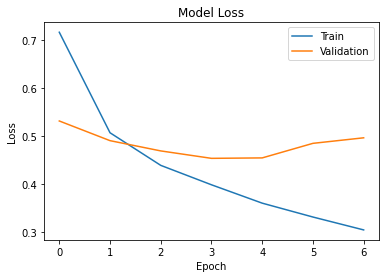

In [ ]:

import matplotlib.pyplot as plt
plt.plot(lossTrain)
plt.plot(lossVal)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

Με βάση το παραπάνω plot βλέπουμε οτι το μοντέλο μας μετά την 2η εποχή αρχίζει να παθαίνει overfitting. Λόγω όμως της τεχνικής early stopping είμαστε σε θέση να χρησιμοποιήσουμε το μοντέλο και τα βάρη που προκύπτουν απο την εποχή 2.

## Evaluation

In [ ]:
_, predictions, true_vals = evaluate(dataloader_val,2)
accuracy_per_class(predictions, true_vals)

100%|██████████| 160/160 [00:59<00:00,  2.68it/s]
                                                                       

Class: 0
Accuracy:1185/1902 - 0.6230283911671924 

Class: 1
Accuracy:3876/4486 - 0.8640213999108337 

Class: 2
Accuracy:3312/3824 - 0.8661087866108786 



# Bert as Feauture Extractor

Θα χρησιμοποιήσουμε τα Contextualized Embeddings που προκύπτουν απο το Bert με σκοπό να εισαχθούν ως είσοδο σε κάποιον απλό Machine Learning Classifier. 

In [8]:
from typing import Callable, List, Optional, Tuple
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.base import TransformerMixin, BaseEstimator
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-uncased")
bert_model = BertModel.from_pretrained("bert-base-multilingual-uncased",num_labels = 3)
class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(
            self,
            tokenizer,
            model,
            max_length: int = 60,
            embedding_func: Optional[Callable[[torch.tensor], torch.tensor]] = None,
    ):
        self.tokenizer = tokenizer
        self.model = model
        self.model.eval()
        self.max_length = max_length
        self.embedding_func = embedding_func

        if self.embedding_func is None:
            self.embedding_func = lambda x: x[0][:, 0, :].squeeze()

    def _tokenize(self, text: str) -> Tuple[torch.tensor, torch.tensor]:
        # Tokenize the text with the provided tokenizer
        tokenized_text = self.tokenizer.encode_plus(text,
                                                    add_special_tokens=True,
                                                    max_length=self.max_length
                                                    )["input_ids"]

        # Create an attention mask telling BERT to use all words
        attention_mask = [1] * len(tokenized_text)

        # bert takes in a batch so we need to unsqueeze the rows
        return (
            torch.tensor(tokenized_text).unsqueeze(0),
            torch.tensor(attention_mask).unsqueeze(0),
        )

    def _tokenize_and_predict(self, text: str) -> torch.tensor:
        tokenized, attention_mask = self._tokenize(text)

        embeddings = self.model(tokenized, attention_mask)
        return self.embedding_func(embeddings)

    def transform(self, text: List[str]):
        if isinstance(text, pd.Series):
            text = text.tolist()

        with torch.no_grad():
            return torch.stack([self._tokenize_and_predict(string) for string in text])

    def fit(self, X, y=None):
        """No fitting necessary so we just return ourselves"""
        return self

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/641M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
import numpy as np
from sklearn import svm
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV,cross_val_score
# split = np.random.choice(
#     ["train", "val"],
#     size=data.shape[0],
#     p=[.75, .25]
# )
# data["split"] = split
# x_train = data[data["split"] == "train"]
# y_train = x_train["Sentiment"]
X_train, X_val, y_train, y_val = train_test_split(data["OriginalTweet"],data['Sentiment'], test_size=0.25,stratify=data['Sentiment'])
print(X_train)
y_train=y_train.astype('int').to_numpy()
# X_train = X_train.to_numpy()
# X_val = X_val.to_numpy()
bert_transformer = BertTransformer(bert_tokenizer, bert_model)
classifier = svm.SVC(C=1000, kernel = 'rbf')
# classifier = ComplementNB(alpha = 1.0)
# classifier = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 10, n_estimators = 500)
model = Pipeline(
    [
        ("vectorizer", bert_transformer),
        ("classifier", classifier),
    ]
)
model.fit(X_train, y_train)



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


11532                         covid socialdistanacing mood
35881                         restore confidence covid via
32790    fuel think crudeoil correct almost since dec r...
31065    one silverlining covidi experience rush overwh...
7207     get lady push get toilet paper coronavirus mak...
                               ...                        
7762     bring back sweep two couple fight last toilet ...
13808    response covid crisis cma say take direct enfo...
37787    nail polish manufacturer produce alcohol base ...
38603    socialdistancing save life thanks frontline wo...
24517                       crazy time high af coronavirus
Name: OriginalTweet, Length: 30633, dtype: object


Pipeline(steps=[('vectorizer',
                 BertTransformer(embedding_func=<function BertTransformer.__init__.<locals>.<lambda> at 0x7ff505de7c20>,
                                 model=BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(105879, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elem...
    (dense): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
  )
),
                                 tokenizer=PreTrainedTokenizer(name_or_path='bert-base-multilingual-uncased', vocab_size=105879, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}))),
                ('classifier', SVC(C=1000))])

In [10]:
from sklearn import metrics
y_val=y_val.astype('int').to_numpy()
y_pred = model.predict(X_val)
# predicted_prob2 = clf3.predict_proba(x_val_new)
m_confusion_test = metrics.confusion_matrix(y_val, y_pred)
print("RF")
print(pd.DataFrame(data = m_confusion_test , columns=['Predicted 0', 'Predicted 1','Predicted 2'],index=['Actual 0', 'Actual 1','Actual 2']))
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))
print(metrics.classification_report(y_pred,y_val))

RF
          Predicted 0  Predicted 1  Predicted 2
Actual 0          770          690          442
Actual 1          319         3225          942
Actual 2          257         1098         2469
Accuracy: 0.6329808068938504
              precision    recall  f1-score   support

           0       0.40      0.57      0.47      1346
           1       0.72      0.64      0.68      5013
           2       0.65      0.64      0.64      3853

    accuracy                           0.63     10212
   macro avg       0.59      0.62      0.60     10212
weighted avg       0.65      0.63      0.64     10212

